In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 


from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.datasets import load_diabetes,load_boston
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
from graph_utils import plot_multiple,plot_xy

%matplotlib inline


# DATA PREPARATION

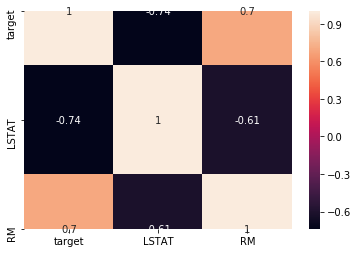

In [2]:
df = pd.DataFrame(load_boston().data, columns=load_boston().feature_names)
df["target"] = load_boston().target

correlated_features = abs(df.corr()["target"]).sort_values(ascending=False)

correlated_features = correlated_features[correlated_features>0.6]

df = df[correlated_features.keys()]

sns.heatmap(df.corr(),annot=True)

In [3]:
df

,target,LSTAT,RM
0,24.0,4.98,6.575
1,21.6,9.14,6.421
2,34.7,4.03,7.185
3,33.4,2.94,6.998
4,36.2,5.33,7.147
...,...,...,...
501,22.4,9.67,6.593
502,20.6,9.08,6.120
503,23.9,5.64,6.976
504,22.0,6.48,6.794


In [4]:
file_path = None

if not(file_path):
    X = np.array(df.drop('target',axis=1))
    y = np.array(df["target"])
else:
    df = pd.read_csv(file_path,keep_default_na=False,na_values="").drop("Unnamed: 0",axis=1)

In [5]:
X

array([[4.98 , 6.575],
       [9.14 , 6.421],
       [4.03 , 7.185],
       ...,
       [5.64 , 6.976],
       [6.48 , 6.794],
       [7.88 , 6.03 ]])

df = pd.DataFrame(X)

for i in range(len(df.columns)-1):
    name = str(df.columns[i])+"_x_"+str(df.columns[i+1])
    df[name] = df[df.columns[i]] * df[df.columns[i+1]]

X = np.array(df)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=31)
print('Train set size',X_train.shape[0],'Test set size',X_test.shape[0])

Train set size 101 Test set size 405


In [7]:
def standardize(df,df_ref):
    return (df - df_ref.mean())/df_ref.std(ddof=1)

def destandardize(df,df_ref):
    return (df * df_ref.std(ddof=1)) + df_ref.mean()

X_train_t = np.transpose(X_train.copy())
X_test_t = np.transpose(X_test.copy())

for i,col in enumerate(X_train_t) :
    X_test_t[i] = standardize(X_test_t[i], col)
    X_train_t[i] = standardize(col, col)
    
X_train_modified = np.transpose(X_train_t)
X_test_modified = np.transpose(X_test_t)

y_train_modified = standardize(y_train,y_train)
y_test_modified = standardize(y_test,y_train)

# REGRESSIONS

In [12]:
def train_model(model,X_train,y_train,X_test,y_test,GS=False):
    reg = model.fit(np.array(X_train), y_train)
    if GS:
        print(model.best_params_)
    for i in range(X_test.shape[0]):
        y_hat_test = reg.predict(np.array(X_test))
        y_hat_train = reg.predict(np.array(X_train))
    return y_hat_test,y_hat_train

def run_models(X_train,y_train,X_test,y_test,models,GS=False,y_hat=None,y_hat_train=None):
    if not(y_hat):
        y_hat = {}
    if not(y_hat_train):
        y_hat_train = {}
    for model_name in models.keys():
        y_hat[model_name],y_hat_train[model_name] = train_model(models[model_name],X_train,y_train,X_test,y_test,GS=GS)  

    return y_hat,y_hat_train

def compute_mse(y_test,y_hat,dict_mse=None):
    if not(dict_mse):
        dict_mse = {}
    for model_name in models.keys():
        dict_mse[model_name] = r2_score(np.array(y_test).reshape(-1,1),np.array(y_hat[model_name]))
        
    return dict_mse

In [13]:
models = {"Linear":LinearRegression(),
          "Ridge":Ridge(),
          "Lasso":Lasso(),
          "Elastic Net":ElasticNet(),
          "LGBM":LGBMRegressor(n_estimators=2000),
          "MLP":MLPRegressor()}

y_hat,y_hat_train = run_models(X_train,y_train,X_test,y_test,models)


dict_mse=compute_mse(y_test,y_hat)
dict_mse_train=compute_mse(y_train,y_hat_train)

y_hat_modified,y_hat_modified_train = run_models(X_train_modified,y_train_modified,X_test_modified,y_test_modified,models)
for model_name in models.keys():
    y_hat_modified[model_name] = destandardize(y_hat_modified[model_name],y_train)
    y_hat_modified_train[model_name] = destandardize(y_hat_modified_train[model_name],y_train)
dict_mse_modified = compute_mse(y_test,y_hat_modified)
dict_mse_modified_train = compute_mse(y_train,y_hat_modified_train)



/usr/local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [14]:
dict_mse_train

{'Linear': 0.6102514734566671,
 'Ridge': 0.6102017025722517,
 'Lasso': 0.5897785778683429,
 'Elastic Net': 0.5693400231073844,
 'LGBM': 0.8214663263799964,
 'MLP': 0.1551943397248825}

In [15]:
dict_mse

{'Linear': 0.6331822426118376,
 'Ridge': 0.6328087820735846,
 'Lasso': 0.6139401228084282,
 'Elastic Net': 0.5947074361717857,
 'LGBM': 0.5898508155560114,
 'MLP': 0.18260884198767868}

Linear


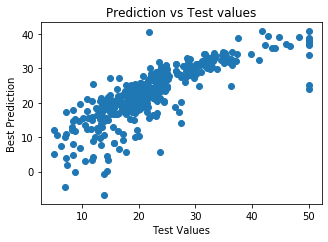

In [16]:
best_model = max(dict_mse, key=dict_mse.get)
print(best_model)

Series = [y_test,y_hat[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter")

In [17]:
dict_mse_modified_train

{'Linear': 0.6102514734566671,
 'Ridge': 0.6102247758360579,
 'Lasso': 0.0,
 'Elastic Net': 0.2189675074275541,
 'LGBM': 0.8256757157057946,
 'MLP': 0.7987602214901552}

In [18]:
dict_mse_modified

{'Linear': 0.6331822426118379,
 'Ridge': 0.6344315767697946,
 'Lasso': -0.008152647548153924,
 'Elastic Net': 0.25444936134739105,
 'LGBM': 0.5972569652950646,
 'MLP': 0.7543938992523584}

MLP


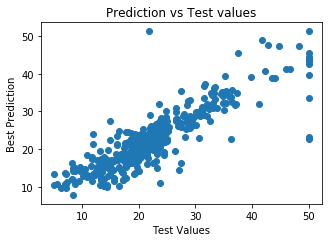

In [19]:
best_model = max(dict_mse_modified, key=dict_mse_modified.get)
print(best_model)

Series = [y_test,y_hat_modified[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter")

# GridSearch

In [20]:

param_grid = {}
n_splits = 5

# MLP

In [21]:
param_grid["MLP"] = {
    'hidden_layer_sizes':[(i,) for i in range(100,1000,100)],
    'activation':['identity', 'tanh', 'relu'],
    'solver':["adam"],
    'learning_rate':["adaptive"],
    'max_iter':[20000],
    'early_stopping':[True],
    'alpha':[10**(-i) for i in range(0,6)]
    
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
MLP_GS = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid["MLP"], cv=gkf,verbose=1)

## LGBM

In [22]:
param_grid["LGBM"] = {
    'boosting_type':["gbdt"],
    'max_depth': [-1],
    'n_estimators':[2000],
    'reg_alpha':[0],
    'reg_lambda':[0],
    'num_leaves':[i for i in range(2,100,2)],
    'learning_rate':[10**(-i) for i in range(0,3)],
    'subsample':[0.95],
    'colsample_bytree':[0.95]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
LGBM_GS = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid["LGBM"], cv=gkf,verbose=1)

## Ridge

In [23]:
param_grid["Ridge"] = {
    'alpha':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Ridge_GS = GridSearchCV(estimator=Ridge(), param_grid=param_grid["Ridge"], cv=gkf,verbose=1)

## Lasso

In [24]:
param_grid["Lasso"] = {
    'alpha':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
Lasso_GS = GridSearchCV(estimator=Lasso(), param_grid=param_grid["Lasso"], cv=gkf,verbose=1)

## ElasticNet

In [25]:
param_grid["ElasticNet"] = {
    'alpha':[i/100 for i in range(1,100)],
    'l1_ratio':[i/100 for i in range(1,100)]
    }
gkf = KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X=X_train_modified, y=y_train_modified)
ElasticNet_GS = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid["ElasticNet"], cv=gkf,verbose=0)

In [26]:
models = {"LGBM GS":LGBM_GS,
          "Ridge GS":Ridge_GS,
          "Lasso GS":Lasso_GS,
          "ElasticNet GS":ElasticNet_GS,
          'MLP GS':MLP_GS
         }




In [27]:
y_hat_modified, y_hat_modified_train = run_models(X_train_modified,
                                                  y_train_modified,
                                                  X_test_modified,
                                                  y_test_modified,
                                                  models,
                                                  GS=True,
                                                  y_hat=y_hat_modified,
                                                  y_hat_train=y_hat_modified_train)
for model_name in models.keys():
    y_hat_modified[model_name] = destandardize(y_hat_modified[model_name],y_train)
    y_hat_modified_train[model_name] = destandardize(y_hat_modified_train[model_name],y_train)
dict_mse_modified=compute_mse(y_test,y_hat_modified,dict_mse=dict_mse_modified)
dict_mse_modified_train=compute_mse(y_train,y_hat_modified_train,dict_mse=dict_mse_modified_train)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 735 out of 735 | elapsed:  1.7min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.95, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 2000, 'num_leaves': 4, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.95}
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 0.99}
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:    0.6s finished


{'alpha': 0.08}
{'alpha': 0.3, 'l1_ratio': 0.01}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   25.7s finished


{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'max_iter': 20000, 'solver': 'adam'}


# RESULTS

In [28]:
dict_mse_modified_train

{'Linear': 0.6102514734566671,
 'Ridge': 0.6102247758360579,
 'Lasso': 0.0,
 'Elastic Net': 0.2189675074275541,
 'LGBM': 0.8256757157057946,
 'MLP': 0.7987602214901552,
 'LGBM GS': 0.7409210591977637,
 'Ridge GS': 0.6102253032691977,
 'Lasso GS': 0.6018064641163492,
 'ElasticNet GS': 0.5929336373777689,
 'MLP GS': 0.10998711793822558}

In [29]:
dict_mse_modified

{'Linear': 0.6331822426118379,
 'Ridge': 0.6344315767697946,
 'Lasso': -0.008152647548153924,
 'Elastic Net': 0.25444936134739105,
 'LGBM': 0.5972569652950646,
 'MLP': 0.7543938992523584,
 'LGBM GS': 0.6540640099339515,
 'Ridge GS': 0.6344195745557779,
 'Lasso GS': 0.6418690712508408,
 'ElasticNet GS': 0.6404906188133108,
 'MLP GS': 0.21420631073562946}

MLP


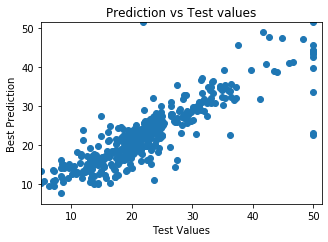

In [30]:
best_model = max(dict_mse_modified, key=dict_mse_modified.get)
print(best_model)
Series = [y_test,y_hat_modified[best_model]]
xlabel = "Test Values"
ylabel = "Best Prediction"
title = "Prediction vs Test values"
plot_xy(Series, xlabel, ylabel, title,kind="Scatter",same_xy=True)